Universidad Simón Bolívar. \\
Departamento de Cómputo Científico. \\
CO-6612, Introducción a Redes Neuronales. \\
TDD 2020. \\
Prof. Minaya Villasana. \\
Amin Arriaga 16-10072. 
# **Tarea 4: Perceptrón Multicapas**

In [8]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from random import uniform, shuffle
from math import e

In [ ]:
# Montamos el drive para obtener los archivos 
# mnist_test.csv,   mnist_train.csv
from google.colab import drive
drive.mount('/content/drive')

## **Implementación del Perceptrón Multicapas**

In [3]:
class MLP:
  """ 
  Implementacion de un perceptron multicapa (MLP: Multi-Layer Perceptron) 
  usando el descenso de gradiente estocastico con momentum como algoritmo de 
  entrenamiento. 
  """

  def __init__(self, eta: float, dim_input: int, alpha: float = 0):
    """
    Inicializacion del perceptron multicapa.

    INPUT:
      - eta:  Tasa de aprendizaje.
      - dim_input:  Dimension de los datos de entrada.
      - alpha:  Momentum. Valor predeterminado: 0.
    """
    self.eta = eta
    self.dim_input = dim_input
    self.alpha = alpha
    # Pesos sinapticos de cada capa.
    self.W = []
    # Funcion de activacion en cada capa y sus respectivas derivadas.
    self.act_functions = []
    self.derived_act_functs = []
    # Dimension de los datos de salida.
    self.dim_output = dim_input


  def add_layer(self, dim: int, phi, dphi, w_min: float = -0.05, w_max: float = 0.05):
    """ 
    Agrega una nueva capa a la red neuronal.

    INPUT:
      - dim:  Numero de neuronas de la capa.
      - phi:  Funcion de activacion.
      - dphi: Derivada de la funcion de activacion.
      - w_min:  Valor minimo de los pesos sinapticos al inicializarlos aleatoriamente.
                Valor predeterminado: -0.05.
      - w_max:  Valor maximo de los pesos sinapticos al inicializarlos aleatoriamente.
                Valor predeterminado: 0.05.
    """
    w = np.random.uniform(low=w_min, high=w_max, size=(dim, self.dim_output + 1))
    self.W.append(w)
    self.act_functions.append(phi)
    self.derived_act_functs.append(dphi)
    # Actualizamos la nueva dimension de los datos de salida.
    self.dim_output = dim


  def predict(self, x: [float]):
    """
    Predice el valor de un dato de entrada.

    INPUT:
      - x:  Dato de entrada

    OUTPUT:
      - [float]:  Clasificacion predicha.
    """
    y = x
    # Por cada capa de la red.
    for k in range(len(self.W)):
      # Insertamos un 1 al resultado de la capa anterior para el sesgo. Luego
      # lo multiplicamos por la matriz de pesos correspondiente a esta capa.
      y = np.append(y, [1])
      A = np.dot(self.W[k], y)
      y = [self.act_functions[k](A[i]) for i in range(len(A))]
    return y


  def predict_train(self, x: [float]):
    """
    Predice el valor de un dato de entrada, almacenando la vecindad y el output
    de cada neurona para usarlos en el entrenamiento.

    INPUT:
      - x:  Dato de entrada

    OUTPUT:
      - [[float]]:  Ouput de cada neurona.
      - [[float]]:  Input de cada neurona.
    """
    # Numero de capas de la red.
    n_layers = len(self.W)
    # Output e input de cada neurona.
    Y, V = [0]*n_layers, [0]*n_layers

    # Para cada k-esima capa de la red seguimos la formula
    # V[k] = W[k]Y[k-1]
    # Y[k] = phi[k](V[k])
    V[0] = np.dot(self.W[0], np.append(x, 1))
    Y[0] = np.array([self.act_functions[0](V[0][i].copy()) for i in range(len(V[0]))])
    for k in range(1, n_layers):
      V[k] = np.dot(self.W[k], np.append(Y[k-1], 1))
      Y[k] = np.array([self.act_functions[k](V[k][i].copy()) for i in range(len(V[k]))])
    return Y, V


  def ecmp(self, X: [[float]], Y: [[float]]):
    """ 
    Error cuadratico medio promediado obtenido para un conjunto de datos.

    INPUT:
      - X:  Conjunto de datos de entrada.
      - Y:  Conjunto de datos de salida.

    OUTPUT:
      - float:  Error cuadratico medio promediado.
    """
    # Numero de datos a clasificar.
    N = len(X)
    err = 0
    for j in range(N):
      d_j = Y[j]
      # Predecimos el valor del j-esimo dato de entrada.
      y_j = self.predict(X[j])
      # Sumamos la diferencia entre lo predicho y el valor correcto.
      err += np.dot(d_j-y_j, d_j-y_j)
    return err/(2*N)


  def train(self, X_train: [[float]],   Y_train: [[float]],   X_test: [[float]], 
            Y_test: [[float]],  epochs: int,  ecmp_min: float = 0, acc_function = None,
            verbose: bool = True):
    """
    Entrena a la red con un conjunto de entrenamiento y otro de prueba durante
    un numero de epocas determinado.

    INPUT:
      - X_train:  Conjunto de datos de entrenamiento de entrada.
      - Y_train:  Conjunto de datos de entrenamiento de salida.
      - X_test:   Conjunto de datos de prueba de entrada.
      - Y_test:   Conjunto de datos de prueba de salida.
      - epochs:   Numero de epocas.
      - ecmp_min:  Error cuadratico medio promediado necesario para finalizar el 
          entrenamiento. Valor predeterminao: 0.
      - acc_function(X, Y, self) Funcion que calcula la precision de la red. Valor
          predeterminado: None.
      - verbose:  Indica si se imprimiran los datos obtenidos en cada epoca.

    OUTPUT:
      - [float]:  Error cuadratico medio promediado obtenido de los datos de
                entrenamiento en cada epoca.
      - [float]:  Error cuadratico medio promediado obtenido de los datos de
                prueba en cada epoca
        Si se especifica una funcion de activacion:
      * [float]:  Precision obtenida de los datos de entrenamiento en cada epoca.
      * [float]:  Precision obtenida de los datos de prueba en cada epoca
    """

    N = len(X_train)
    indexes = [i for i in range(N)]
    n_layers = len(self.W)
    # Error cuadratico medio obtenido con los datos de entrenamiento
    # y prueba en cada epoca.
    ecm_train = []
    ecm_test = []

    if acc_function != None:
      acc_train = []
      acc_test = []
    # Variacion de los pesos.
    varW = [np.array([np.array([0 for _ in w_i]) for w_i in w]) for w in self.W]

    if not verbose: print("Epochs: [" + " "*epochs + "]")

    for i in range(epochs):
      shuffle(indexes)
      # Gradiente local de cada neurona.
      delta = [0]*n_layers

      for j in indexes:
        d_j = Y_train[j]
        x_j = X_train[j]
        Y, V = self.predict_train(x_j)

        # Calculamos el gradiente local de las neuronas en la ultima capa.
        delta[n_layers-1] = [(d_j - Y[len(Y)-1])[k] * \
          self.derived_act_functs[n_layers-1](V[n_layers-1][k]) for k in range(len(V[n_layers-1]))]
        # Verificamos que no estemos en la primera capa.
        y_j = Y[len(Y)-2] if len(Y) > 1 else x_j
        # Calculamos la variacion de los pesos.
        varW[n_layers-1] = self.eta * np.outer(delta[n_layers-1], np.append(y_j, 1)) + \
          self.alpha * varW[n_layers - 1] 
        # Actualizamos los pesos.
        self.W[n_layers-1] += varW[n_layers-1]

        # BackPropagation.
        for k in range(n_layers-2, -1, -1):
          # Verificamos que no estemos en la primera capa.
          outp_k = Y[k-1] if k > 0 else x_j
          # Calculamos el gradiente local de las neuronas de la k-esima capa.
          delta[k] = [self.derived_act_functs[k](V[k][h]) * \
            np.dot(delta[k+1], np.transpose(self.W[k+1])[h]) for h in range(len(V[k]))]
          # Calculamos la variacion de los pesos.
          varW[k] = self.eta * np.outer(delta[k], np.append(outp_k, 1)) + self.alpha*varW[k]
          # Actualizamos los pesos.
          self.W[k] += varW[k]

      # Calculamos y almacenamos los errores cuadraticos medios promediados.
      new_ecm_train = self.ecmp(X_train, Y_train)
      new_ecm_test = self.ecmp(X_test, Y_test)
      ecm_train.append(new_ecm_train)
      ecm_test.append(new_ecm_test)
      if acc_function != None:
        # Calculamos y almacenamos las precisiones.
        new_acc_train = acc_function([self.predict(x) for x in X_train], Y_train)
        new_acc_test = acc_function([self.predict(x) for x in X_test], Y_test)
        acc_train.append(new_acc_train)
        acc_test.append(new_acc_test)
        if verbose: 
          print("Epoch:", i+1, "| ECMP entrenamiento:", round(new_ecm_train, 4),
                "| ECMP prueba:", round(new_ecm_test, 4),
                "| ACC entrenamiento: ", round(new_acc_train, 4),
                "| ACC prueba: ", new_acc_test)
      elif verbose:
        print("Epoch:", i+1, "| ECMP datos de entrenamiento:", new_ecm_train,
              "| ECMP datos de prueba:", new_ecm_test)
      if not verbose: print("\b"*(11 + epochs) + "Epochs: [" + "#"*(i+1) + " "*(epochs-i-1) + "]")

      # Si alcanzamos el error minimo, finalizamos el entrenamiento.
      if new_ecm_train <= ecmp_min:
        break

    if acc_function != None:  
      return ecm_train, ecm_test, acc_train, acc_test
    else:
      return ecm_train, ecm_test
                                  

## **$Experimento$ $N^o 1$**
Realice su entrenamiento variando el número de unidades ocultas con $n = 20, 50, 100$. Incluya el sesgo en cada nodo de la red. Grafique el error de entrenamiento y de validación. Discuta el efecto del número de neuronas en el error de entrenamiento y sobre la validación. Compare los resultados con las tareas anteriores.

In [4]:
def digitToCanon(x: int):
  """ Dado un digito, retorna un vector de ceros excepto en la posicion del 
  digito, donde habra un 1. """
  r = [0]*10
  r[x] = 1
  return np.array(r)


def readCSV(file: str):
  """ 
  Leer datos .csv de MNIST para el problema de los digitos.

  Input: 
    file:  Nombre del archivo csv.
  Output:
    [[float]]   Conjunto de imagenes de los digitos
    [[int]]     Respuesta a cada dato en X.
  """
  with open(file, newline='') as File:  
      reader = csv.reader(File)
      X = []
      Y = []
      for r in reader:
          for i in range(1, len(r)):
              r[i] = float(r[i])/255
          Y.append(digitToCanon(int(r.pop(0))))
          r = np.array(r)
          map(float, r)
          X.append(r)
          
  return X, Y


def logist(x: float, alpha: float = 1):
  """ Funcion logistica.  
    logist(x) -> 1/(1 + exp(-alpha*x)) 
  """
  return 1/(1+e**(-alpha*x))


def d_logist(x: float, alpha: float = 1):
  """ Derivada de la funcion logistica. 
    d_logist(x) -> alpha*logist(x)(1 - logist(x))"""
  l = logist(x, alpha = alpha)
  return alpha*l*(1 - l) 


def acc_mnist(Y_predict: [[float]], Y: [[float]]):
  """ Calcula la precision de una red al predecir los datos de los digitos de 
  MNIST. Retornara dos tipos de precision. La primera considera que un patron 
  pertenece a la clase de la neurona con el output mas grande. En la segunda, un 
  patron no perteneciente a la clase de una neurona output debe tener un valor
  menor o igual 0.1, y mayor o igual a 0.9 si si pertenece.

  INPUT:
    - Y_predict:  Conjunto de datos predecidos por la red
    - Y:  Conjunto de datos correctos.

  OUTPUT:
    float:  Precision version 1 de la red al predecir los datos.
    float:  Precision version 2 de la red al predecir los datos.
  """
  N = len(Y)
  acc_1 = 0
  acc_2 = 0
  for j in range(N):
      y_j = Y_predict[j]
      # Para el primer tipo de precision.
      y1_j = [int(y/max(y_j)) for y in y_j]
      # Para el segundo tipo de precision.
      y2_j = []
      for y in y_j:
        if y <= 0.1: y2_j.append(0)
        elif y >= 0.9: y2_j.append(1)
        else: y2_j.append(y)     

      d_j = Y[j]
      # Si d_j == y_j.
      if all(y1_j[k] == d_j[k] for k in range(len(y1_j))):
          acc_1 += 1
      if all(y2_j[k] == d_j[k] for k in range(len(y2_j))):
          acc_2 += 1

  return acc_1/N, acc_2/N

def print_conclusion(title: str, title_g: str, ecm_train, ecm_test, acc_train, acc_test):
  epochs = [i for i in range(1, 51)]
  # Resultados obtenidos en la tarea del Adaline con 0.001 y funcion de activacion
  # logistica, el cual fue la mejor red.
  acc_adeline = [0.8857166666666667,0.8961,0.9015,0.9043833333333333,0.9064166666666666,0.9084166666666667,
                0.9085,0.9102833333333333,0.9112666666666667,0.9125166666666666,0.9124833333333333,0.9130166666666667,
                0.9136166666666666,0.9146166666666666,0.9141166666666667,0.9145833333333333,0.9144833333333333,
                0.9166166666666666,0.9153666666666667,0.9162,0.91655,0.9173833333333333,0.9170333333333334,
                0.9179666666666667,0.91775,0.91765,0.91815,0.9184166666666667,0.91815,0.9185833333333333,
                0.9181833333333334,0.9190333333333334,0.9188833333333334,0.9193,0.9195333333333333,0.9187666666666666,
                0.9185666666666666,0.92015,0.9199166666666667,0.9195166666666666,0.9200833333333334,0.9203333333333333,
                0.9201666666666667,0.9204833333333333,0.9207666666666666,0.9198166666666666,0.92125,0.9206666666666666,
                0.9207833333333333,0.9210833333333334]

  print("\t\t\033[1;1mMLP CON " + title)
  # Graficamos el Error Cuadratico Medio Promediado.
  plt.plot(epochs, ecm_train, label="Datos de entrenamiento")
  plt.plot(epochs, ecm_test, label="Datos de prueba")
  plt.xlabel("Epoca")
  plt.ylabel("Error cuadratico medio promediado")
  plt.title("Evolucion del ECMP para " + title_g)
  plt.legend()
  plt.show()
  print("ECMP minimo obtenido con los datos de entrenamiento: ", min(ecm_train))
  print("ECMP minimo obtenido con los datos de prueba: ", min(ecm_test))

  # Graficamos la Precision version 1.
  acc_train_v1 = [a[0] for a in acc_train]
  acc_test_v1 = [a[0] for a in acc_test]
  plt.plot(epochs, acc_train_v1, label="Datos de entrenamiento")
  plt.plot(epochs, acc_test_v1, label="Datos de prueba")
  plt.plot(epochs, acc_adeline, label="Adaline")
  plt.xlabel("Epoca")
  plt.ylabel("Precision")
  plt.title("Evolucion de la precision version 1 para " + title_g)
  plt.legend()
  plt.show()
  print("Precision maxima alcanzada con los datos de entrenamiento: ", max(acc_train_v1))
  print("Precision maxima alcanzada con los datos de prueba: ", max(acc_test_v1))

  # Graficamos la Precision version 2.
  acc_train_v2 = [a[1] for a in acc_train]
  acc_test_v2 = [a[1] for a in acc_test]
  plt.plot(epochs, acc_train_v2, label="Datos de entrenamiento")
  plt.plot(epochs, acc_test_v2, label="Datos de prueba")
  plt.xlabel("Epoca")
  plt.ylabel("Precision")
  plt.title("Evolucion de la precision version 2 para " + title_g)
  plt.legend()
  plt.show()
  print("Precision maxima alcanzada con los datos de entrenamiento: ", max(acc_train_v2))
  print("Precision maxima alcanzada con los datos de prueba: ", max(acc_test_v2), "\n\n")

In [5]:
# Obtenemos los datos de los digitos.
X_train, Y_train = readCSV("/content/drive/My Drive/mnist_train.csv")
X_test, Y_test = readCSV("/content/drive/My Drive/mnist_test.csv")

Al comparar el perceptron multicapa con el adaline, usaremos los resultados obtenidos al cambiar la funcion de activacion lineal por la logistica. Si bien debido a este cambio ya no se considera un adaline, se obtuvo un mejor resultado que con los otros adalines, por lo tanto, dichos resultados representan una cota superior para el rendimiento obtenido en la tarea anterior.

In [62]:
def experimento_1(*N):
  """ 
  Implementacion del Experimento No 1.

  INPUT:  
    - N:  Conjunto de numero de unidades en la capa oculta.
  """
  for n in N:
    # Creamos la RNA con las especificaciones dadas.
    rna = MLP(0.1, 28*28, alpha = 0.9)
    rna.add_layer(n, logist, d_logist)
    rna.add_layer(10, logist, d_logist)
    # Entrenamos la red.
    ecm_train, ecm_test, acc_train, acc_test = rna.train(X_train, Y_train, X_test, Y_test, 50, 
                                                acc_function = acc_mnist, verbose = False) 
    print_conclusion(str(n) + " NEURONAS EN LA CAPA OCULTA.", "n = " + str(n),
                     ecm_train, ecm_test, acc_train, acc_test)

Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs: [#######                                           ]
Epochs: [########       

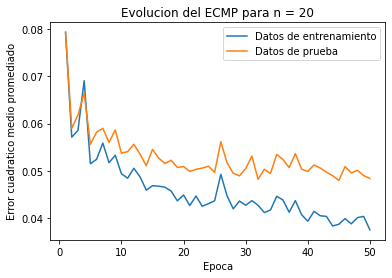

ECMP minimo obtenido con los datos de entrenamiento:  0.03756750635281754
ECMP minimo obtenido con los datos de prueba:  0.048007627073659236


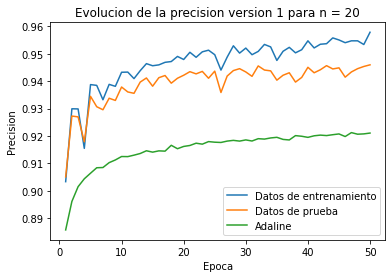

Precision maxima alcanzada con los datos de entrenamiento:  0.9579
Precision maxima alcanzada con los datos de prueba:  0.946


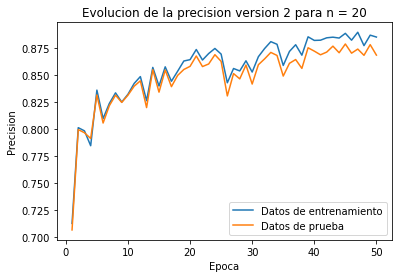

Precision maxima alcanzada con los datos de entrenamiento:  0.8896833333333334
Precision maxima alcanzada con los datos de prueba:  0.8788
Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs:

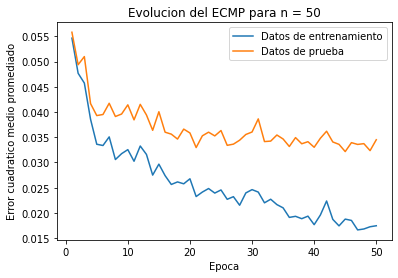

ECMP minimo obtenido con los datos de entrenamiento:  0.01662235866325285
ECMP minimo obtenido con los datos de prueba:  0.03216174546235262


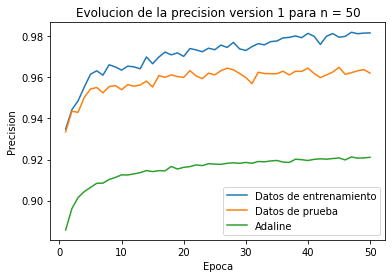

Precision maxima alcanzada con los datos de entrenamiento:  0.9819833333333333
Precision maxima alcanzada con los datos de prueba:  0.9649


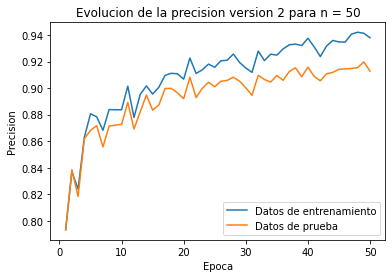

Precision maxima alcanzada con los datos de entrenamiento:  0.9420666666666667
Precision maxima alcanzada con los datos de prueba:  0.9197
Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs:

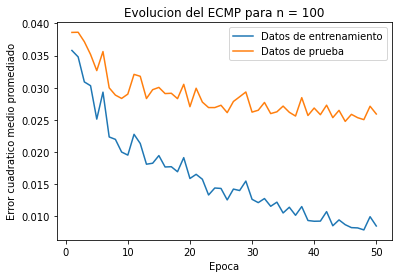

ECMP minimo obtenido con los datos de entrenamiento:  0.007866016119940578
ECMP minimo obtenido con los datos de prueba:  0.024755360021158346


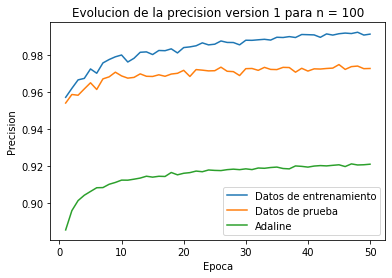

Precision maxima alcanzada con los datos de entrenamiento:  0.9921
Precision maxima alcanzada con los datos de prueba:  0.9747


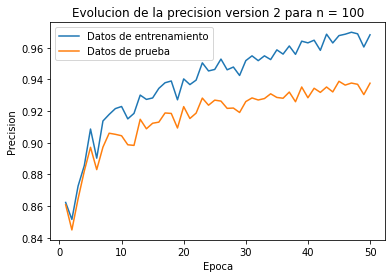

Precision maxima alcanzada con los datos de entrenamiento:  0.9698
Precision maxima alcanzada con los datos de prueba:  0.9388


In [63]:
experimento_1(20, 50, 100)

### **Conclusiones del Experimento 1:**

  * La eficacia del perceptrón múlticapa es muy superior al del adaline (y por lo tanto al del perceptrón de una capa) en la clasificación de estos datos.
  * A pesar de las grandes restricciones, la red puede obtener una precisión alta en la versión 2, por lo que muchos datos son clasificados con gran "seguridad".
  * Mientras más neuronas en la capa oculta:
    * Mayor capacidad de generalizacion, al menos en este experimento, pues aumenta la eficacia al clasificar los datos de validación.
    * Más estabilidad en la evolución del aprendizaje.
    * Mayor tiempo de entrenamiento. En mi caso, de 1 minuto y medio por época para $n=20$ a poco más de 3 minutos por época para $n=100$. 
    * Mayor diferencia entre los errores cometidos con los datos de entrenamiento y los datos de prueba, lo que indica que la red es más capaz de aprenderse de memoria los datos. Por lo tanto, hay que tener cuidado con el overfitting.

## **$Experimento$ $N^o 2$**
Con $n = 100$ y $\eta = 0.1$, realice entrenamientos para $\alpha = 0, 0.25, 0.5$. Compare el entrenamiento con respecto al experimento 1 en relación a los errrores, número de épocas para entrenar y cualquier indicio de sobre-entrenamiento.


In [6]:
def experimento_2(*A):
  """ 
  Implementacion del Experimento No 2.
  INPUT:  
    - A:  conjunto de momentums.
  """
  for a in A:
    # Creamos la RNA con las especificaciones dadas.
    rna = MLP(0.1, 28*28, alpha = a)
    rna.add_layer(100, logist, d_logist)
    rna.add_layer(10, logist, d_logist)
    # Entrenamos la red.
    ecm_train, ecm_test, acc_train, acc_test = rna.train(X_train, Y_train, X_test, Y_test, 
                                                         50, acc_function = acc_mnist, verbose = False)
    print_conclusion("MOMENTUM = " + str(a) + ".", "alpha = " + str(a),
                     ecm_train, ecm_test, acc_train, acc_test)

Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs: [#######                                           ]
Epochs: [########       

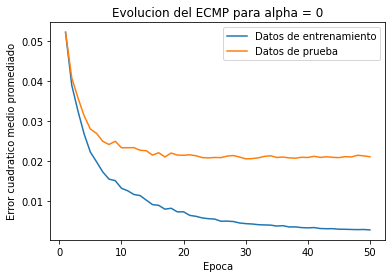

ECMP minimo obtenido con los datos de entrenamiento:  0.002773763320859615
ECMP minimo obtenido con los datos de prueba:  0.020569488695877783


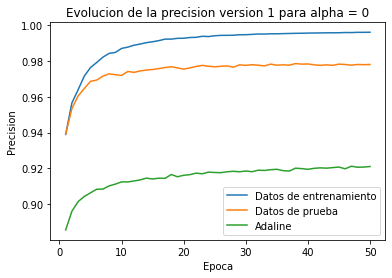

Precision maxima alcanzada con los datos de entrenamiento:  0.9959833333333333
Precision maxima alcanzada con los datos de prueba:  0.9785


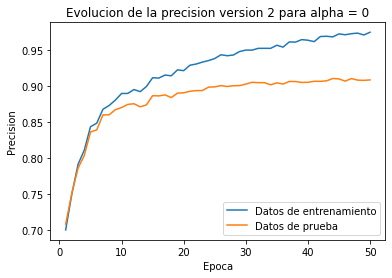

Precision maxima alcanzada con los datos de entrenamiento:  0.9743333333333334
Precision maxima alcanzada con los datos de prueba:  0.9101 


Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epoc

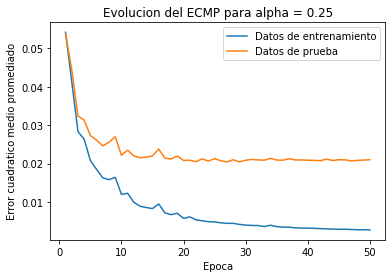

ECMP minimo obtenido con los datos de entrenamiento:  0.0027534323083002045
ECMP minimo obtenido con los datos de prueba:  0.020428844793718624


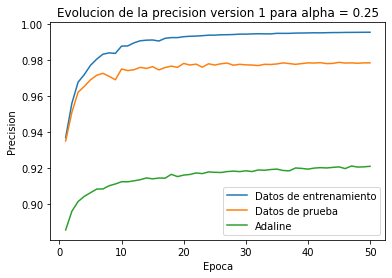

Precision maxima alcanzada con los datos de entrenamiento:  0.9956333333333334
Precision maxima alcanzada con los datos de prueba:  0.9789


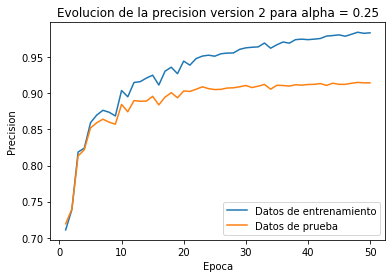

Precision maxima alcanzada con los datos de entrenamiento:  0.9847166666666667
Precision maxima alcanzada con los datos de prueba:  0.9152 


Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epoc

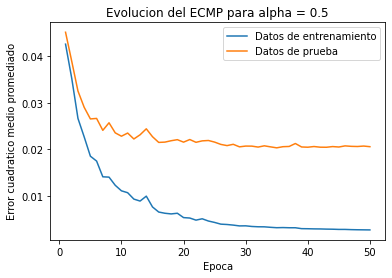

ECMP minimo obtenido con los datos de entrenamiento:  0.002714525719804639
ECMP minimo obtenido con los datos de prueba:  0.020352424548743083


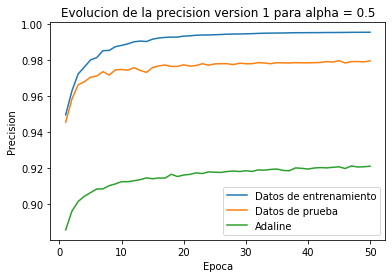

Precision maxima alcanzada con los datos de entrenamiento:  0.9954833333333334
Precision maxima alcanzada con los datos de prueba:  0.9797


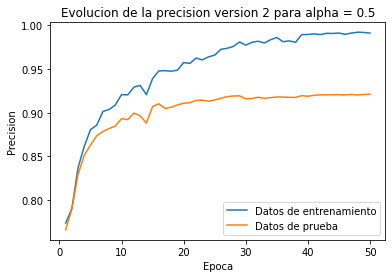

Precision maxima alcanzada con los datos de entrenamiento:  0.9919833333333333
Precision maxima alcanzada con los datos de prueba:  0.9211 




In [7]:
experimento_2(0, 0.25, 0.5)

### **Conclusiones del Experimento 2**
Con respecto a los distintos $\alpha$ usados, mientras mayor es, la capacidad de la red de clasificar correctamente los datos de validación aumenta y también la curva de evolución del error y la precisión son más suaves, por lo que el parámetro de momentum ayuda en el entrenamiento (al menos para este experimento). A

Sin embargo, en comparación al $Experimento$ $N^o1$ ocurre algo curioso: para $\alpha = 0.5$ el ECM y la precisiñon version 1 dieron mejores resultados, sin embargo, para $\alpha = 0.9$, correspondiente al primer experimento, la precisión version 2 fue mayor. Esto pudo haber sido causado por la aleatoriedad en la inicialización de los pesos, sin embargo la diferencia fue de casi 0.02, lo cual es "bastante" para la precisión. Por lo tanto, podría deberse a que con un $\alpha$ no tan alto de $0.5$ la red aprende a clasificar correctamente más datos, pero a costa de tener mas incertidumbre. Es decir, que la red con $\alpha = 0.5$ prefiera que todas o varias de las neuronas de salida den un valor alto (mayor a $0.1$), pero que la neurona con la clase correcta tenga el mayor valor. Mientras que la red con $\alpha = 0.9$ prefiera que el patrón este muy bien clasificado (cumpliendo las restricciones de la precisión versión 2) a costa de que algunos otros patrones queden mal clasificados (incluso para la precisión versión 1). Estas son solo suposiciones respecto a lo observado y se necesitarían mas pruebas para poder confirmarlo.

## **$Experimento$ $N^o 3$**
Fije $n = 100, \alpha = 0.9$. Entrene dos redes. La primera red se entrenará con 1/4 del conjunto de entrenamiento y la segunda con la mitad del conjunto de entrenamiento (asegurese en cada caso estar tomando datos de las 10 clases). Comente sus resultados en relación al experimento 1.

In [8]:
# Primero nos aseguraremos de que estamos tomando datos de las 10 clases.
def numbers(Y):
  """ Esta funcion nos indicara cuantos patrones de cada clase hay en el
  subconjunto de los datos MNIST dado. """
  N = np.array([0]*10, dtype="float64")
  for y in Y:
    N += y
  print(N)

numbers(Y_train[:int(len(Y_train)/2)])
numbers(Y_train[:int(len(Y_train)/4)])

[2961. 3423. 2948. 3073. 2926. 2709. 2975. 3107. 2875. 3003.]
[1496. 1690. 1462. 1548. 1468. 1318. 1490. 1593. 1432. 1503.]


Podemos notar que los datos de MNIST están repartidos de manera más o menos uniforme, por lo que simplemente se pueden tomar los primeros N datos sin preocuparse por dejar una clase poco representada.

In [9]:
def experimento_3(*P):
  """ 
  Implementacion del Experimento No 3.
  INPUT:  
    - P:  Conjunto de numero de partes en las que se dividiran los datos.
  """
  for p in P:
    X_train_p = X_train[:int(len(X_train)/p)]
    Y_train_p = Y_train[:int(len(Y_train)/p)]
    # Creamos la RNA con las especificaciones dadas.
    rna = MLP(0.1, 28*28, alpha = 0.9)
    rna.add_layer(100, logist, d_logist)
    rna.add_layer(10, logist, d_logist)
    # Entrenamos la red.
    ecm_train, ecm_test, acc_train, acc_test = rna.train(X_train_p, Y_train_p, X_test, Y_test, 50, 
                                                        acc_function = acc_mnist, verbose = False)
    print_conclusion("1/" + str(p) + " DE LOS DATOS.", 
                     "1/" + str(p) + " parte de los datos.",
                     ecm_train, ecm_test, acc_train, acc_test)

Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs: [#######                                           ]
Epochs: [########       

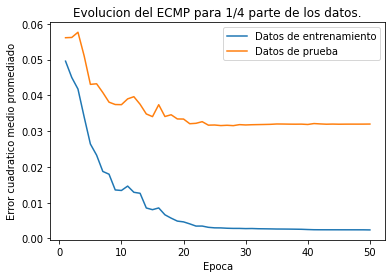

ECMP minimo obtenido con los datos de entrenamiento:  0.002378026721454284
ECMP minimo obtenido con los datos de prueba:  0.031536585784191676


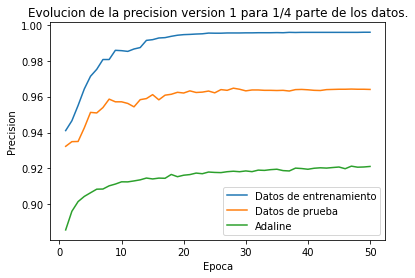

Precision maxima alcanzada con los datos de entrenamiento:  0.9958666666666667
Precision maxima alcanzada con los datos de prueba:  0.9647


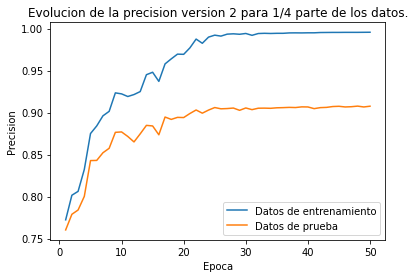

Precision maxima alcanzada con los datos de entrenamiento:  0.9956
Precision maxima alcanzada con los datos de prueba:  0.9077 


Epochs: [                                                  ]
Epochs: [#                                                 ]
Epochs: [##                                                ]
Epochs: [###                                               ]
Epochs: [####                                              ]
Epochs: [#####                                             ]
Epochs: [######                                            ]
Epochs: [#######

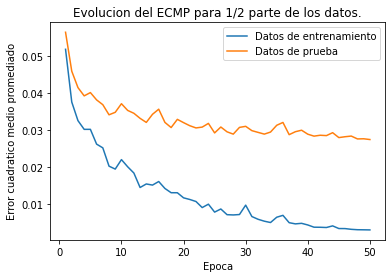

ECMP minimo obtenido con los datos de entrenamiento:  0.0030464301617768893
ECMP minimo obtenido con los datos de prueba:  0.02741976447267495


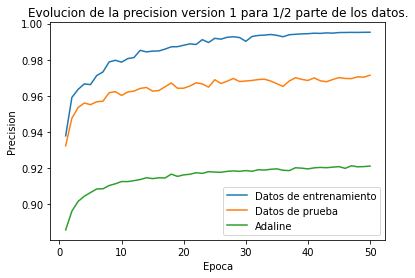

Precision maxima alcanzada con los datos de entrenamiento:  0.9952
Precision maxima alcanzada con los datos de prueba:  0.9714


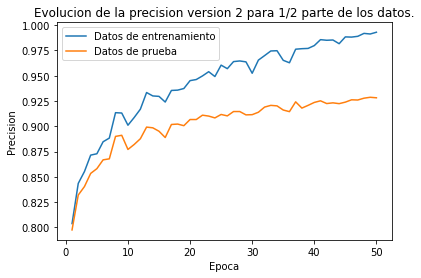

Precision maxima alcanzada con los datos de entrenamiento:  0.9930333333333333
Precision maxima alcanzada con los datos de prueba:  0.9287 




In [10]:
experimento_3(4, 2)

### **Conclusiones del Experimento 3:**

Con respecto al $Experimento$ $N^o1$, mientras menos datos de entrenamiento, menos precisión con los datos de prueba, lo que indica que la capacidad de generalización de la red disminuye. Sin embargo, con la mitad de los datos se obtuvo una precisión versión 2 mayor que las redes del $Experimento$ $N^o2$, lo que refuerza la conclusión obtenida en dicho experimento.